# CS109A - Final Project - Milestone 3

# Canvas Group - Final Project # 150

# Group Members - Akhil Srivastava, Han Truong, Yuying Qian

# Price Prediction using LSTM Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

register_matplotlib_converters()

verbose = False

# Used to parse 'Date Time' column values as pandas DatetimeIndex
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

## Data Reader and Normalization Functions

In [2]:
# Reads Data Downloaded from Yahoo!
def read_yahoo_data(file_name):
    # Read the file and parse 'Date' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['Date'], date_parser=dateparse)

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Adj Close' and 'Volume' columns as they are not needed
    df = df.drop(['Adj Close', 'Volume'], 1)
    
    return df

# Reads Data Downloaded from Bloomberg
def read_bloomberg_data(file_name):
    # Read the file and parse 'DATE' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['DATE'], date_parser=dateparse)
    
    df.columns = ['Date','Open','High','Low','Close','Volume']

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)
    
    return df

def perform_scaling(df):    
     # Create a new dataframe for the scaled values
    df_scaled = df.copy()

    # Variable to save the MinMaxScaler scalar object used for open price transformation
    scalar_open = None

    # Scale the data
    for column in df_scaled.columns:
        # Create a new MinMaxScaler scalar object 
        scaler = MinMaxScaler(feature_range = (0, 1))

        # Apply the transformaion on current column
        df_scaled[column] = scaler.fit_transform(df_scaled[[column]])

        # Save the MinMaxScaler object used for open price for reverse transformation
        if column == 'Open':
            scalar_open = scaler
            
    return df_scaled, scalar_open

# Common Functions for all the Models

In [3]:
# Given history displays loss and RMSE curves
def plot_loss_and_rmse(history):
    # Extract loss and accuracy
    loss = history.history['loss']
    rmse = history.history['rmse']

    val_loss = history.history['val_loss']
    val_rmse = history.history['val_rmse']

    epochs = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
    
    ax[0].plot(epochs, loss, '-o', label='Training Loss')
    ax[0].plot(epochs, val_loss, '-o', color='r', label='Validation Loss')
    ax[0].grid(color='black', which='major', linestyle='dashed')
    ax[0].set_title('Training and Validation Loss', fontsize=18)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=12)

    ax[1].plot(epochs, rmse, '-o', label='Training RMSE')
    ax[1].plot(epochs, val_rmse, '-o', color='r', label='Validation RMSE')
    ax[1].grid(color='black', which='major', linestyle='dashed')
    ax[1].set_title('Training and Validation RMSE', fontsize=18)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('RMSE', fontsize=15)
    ax[1].legend(fontsize=12)

    plt.show();

In [4]:
def build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, epochs, look_ahead):
    
    # Create the model
    model = Sequential()

    # Add LSTM and Dropout Layers
    model.add(CuDNNLSTM(units=150, return_sequences=True,
                        input_shape=(train_features_set.shape[1], train_features_set.shape[2])))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150))
    model.add(Dropout(0.2))

    # Add dense layers
    model.add(Dense(units = look_ahead))

    # Print the model summary
    print("\nSummary of the model:\n")
    model.summary()

    # Compile the Model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

    print("\nTraining the model...\n")

    # Train the model
    history = model.fit(train_features_set,
                        train_labels,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=(val_features_set, val_labels),
                        verbose=verbose)

    print("Training completed!\n")
    
    return model, history

In [5]:
# Read Data
df_apple = read_bloomberg_data('./data/Apple.csv')

# Exclude data before '2010-01-04'
df_apple = df_apple['2010-01-04':]

In [6]:
df_apple.describe()

,Open,High,Low,Close,Volume
count,2737.000000,2737.000000,2737.000000,2737.000000,2.737000e+03
mean,32.708361,33.045324,32.368705,32.720336,2.888866e+08
std,22.656615,22.970535,22.327845,22.664399,2.293796e+08
min,6.870000,7.000000,6.795000,6.859000,4.544818e+07
25%,17.344000,17.523000,17.169000,17.365000,1.228669e+08
50%,26.800000,27.000000,26.545000,26.778000,2.047526e+08
75%,42.580000,42.948000,42.250000,42.545000,3.912999e+08
max,137.590000,137.980000,130.530000,134.180000,1.880987e+09


In [7]:
df_apple.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,7.623,7.661,7.585,7.643,493728200.0
2010-01-05,7.664,7.700,7.616,7.656,601904016.0
2010-01-06,7.656,7.687,7.527,7.535,552158376.0
2010-01-07,7.563,7.571,7.466,7.521,477078140.0
2010-01-08,7.511,7.571,7.466,7.571,447876324.0


In [8]:
df_apple.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-09,120.50,121.990,116.05,116.32,154515315.0
2020-11-10,115.55,117.590,114.13,115.97,138023390.0
2020-11-11,117.19,119.630,116.44,119.49,112294954.0
2020-11-12,119.62,120.530,118.57,119.21,103350674.0
2020-11-13,119.44,119.672,117.87,119.26,81688586.0


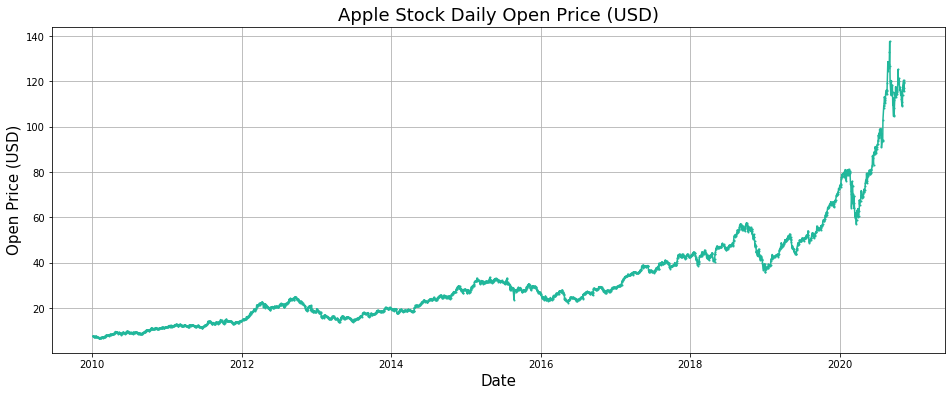

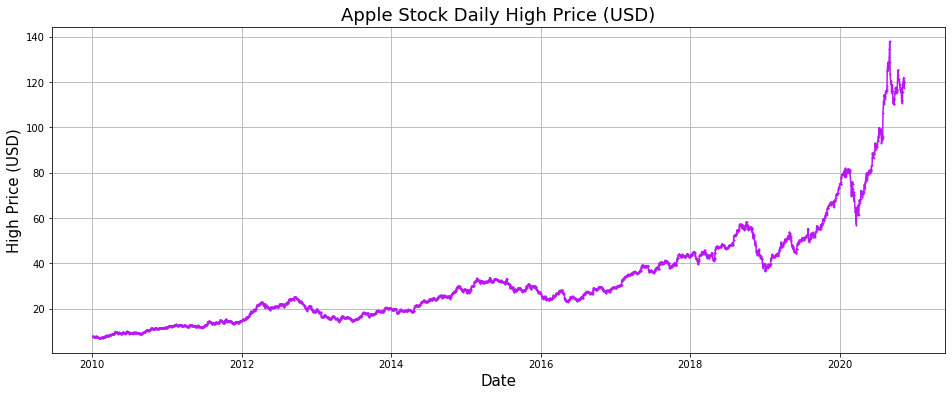

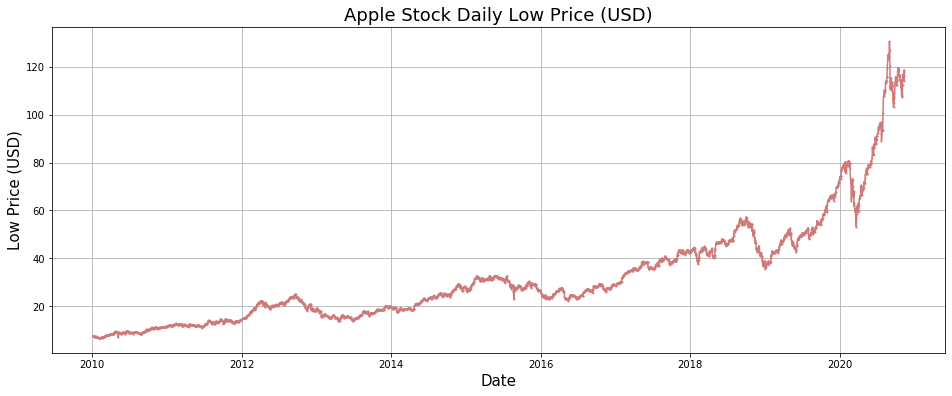

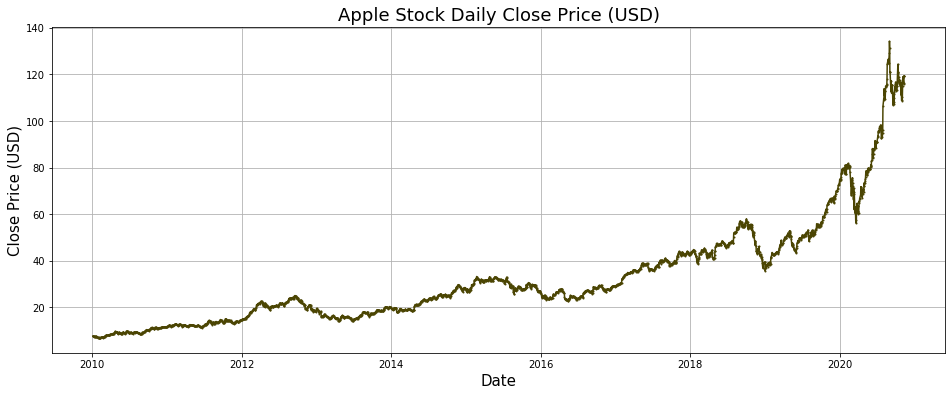

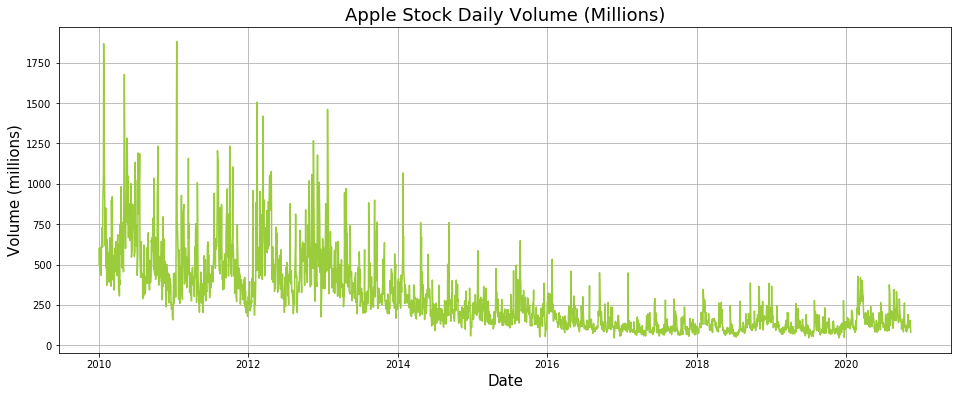

In [9]:
# Display Price Charts
for column in df_apple.columns:
    if column == 'Volume':
        continue
    plt.figure(figsize=(16, 6))
    plt.plot(df_apple.index, df_apple[column], "-o", ms='1', color=np.random.rand(3,))
    plt.title("Apple Stock Daily " + column + " Price (USD)", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(column + " Price (USD)", fontsize=15)
    plt.grid(True);

# Display Volume Chart
plt.figure(figsize=(16, 6))
plt.plot(df_apple.index, df_apple.Volume/1e6, color=np.random.rand(3,))
plt.title("Apple Stock Daily Volume (Millions)", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Volume (millions)", fontsize=15)
plt.grid(True);

In [10]:
# Create a new dataframe for the scaled values
df_apple_scaled = df_apple.copy()

# Variable to save the MinMaxScaler scalar object used for open price transformation
scalar_open = None

# Scale the data
for column in df_apple_scaled.columns:
    # Create a new MinMaxScaler scalar object
    scaler = MinMaxScaler(feature_range = (0, 1))
    
    # Apply the transformaion on current column
    df_apple_scaled[column] = scaler.fit_transform(df_apple_scaled[[column]])
    
    # Save the MinMaxScaler object used for open price for reverse transformation
    if column == 'Open':
        scalar_open = scaler

In [11]:
# Number of past values to be used for prediction
window_size = 60

# Compute Training, Validation and Test Set Sizes
training_size = len(df_apple_scaled.loc[:'2020-05-29']) - window_size
validation_size = len(df_apple_scaled.loc['2020-06-01':'2020-10-16'])
test_size = len(df_apple_scaled.loc['2020-10-19':])

# Print Training, Validation and Test Set Sizes
print("Training Size:", training_size)
print("Validation Size:", validation_size)
print("Test Size:", test_size)

Training Size: 2559
Validation Size: 98
Test Size: 20


# Model 1 - Univariate Model

In [ ]:
# Number of days to predict
look_ahead = 1

# Convert dataframe to numpy array
apple_open = df_apple_scaled[['Open']].values

# Extract datetime for the test data from the dataframe index
dates_1 = df_apple_scaled.tail(test_size).index.format()

# Create Training, Validation and Test Feature Sets and Labels
train_features_set = []
train_labels = []

val_features_set = []
val_labels = []

test_features_set = []
test_labels = []

for i in range(window_size, len(apple_open)):
    if i < window_size + training_size:
        train_features_set.append(apple_open[i-window_size:i, 0])
        train_labels.append(apple_open[i, 0])
    elif i < (window_size + training_size + validation_size):
        val_features_set.append(apple_open[i-window_size:i, 0])
        val_labels.append(apple_open[i, 0])
    else:
        test_features_set.append(apple_open[i-window_size:i, 0])
        test_labels.append(apple_open[i, 0])

# Print size of Training, Validation and Test Feature Sets and Labels
print("Training Feature Set and Label Sizes:", len(train_features_set), len(train_labels))
print("Validation Feature Set and Label Sizes:", len(val_features_set), len(val_labels))
print("Test Feature Set and Label Sizes:", len(test_features_set), len(test_labels))

In [ ]:
# Convert features set and label lists to numpy arrays
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
val_features_set, val_labels = np.array(val_features_set), np.array(val_labels)
test_features_set, test_labels = np.array(test_features_set), np.array(test_labels)

# Print Shape of Training, Validation and Test Feature Sets
print("Training Features Shape:", train_features_set.shape)
print("Validation Features Shape:", val_features_set.shape)
print("Test Features Shape:", test_features_set.shape)
print("\n")

# Reshape Training, Validation and Test Feature Sets to fit LSTM input shape
train_features_set = np.reshape(train_features_set, (train_features_set.shape[0], train_features_set.shape[1], 1))
val_features_set = np.reshape(val_features_set, (val_features_set.shape[0], val_features_set.shape[1], 1))
test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))

# Print Shape of Training, Validation and Test Feature Sets
print("Training Features Shape:", train_features_set.shape)
print("Validation Features Shape:", val_features_set.shape)
print("Test Features Shape:", test_features_set.shape)
print("\n")

# Print Shape of Training, Validation and Test Labels
print("Training Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Features Labels:", test_labels.shape)

In [ ]:
# Create and train a new sequential model as per the specifications
model_1, history_1 = build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, 100, look_ahead)

# Save the model
model_1.save('apple_open_model_1.h5', save_format='tf')

In [ ]:
# Display loss and RMSE curves
plot_loss_and_rmse(history_1)

**Comment on Overfitting: As validation loss and RMSE are very high as compared to the training loss and RMSE respectively, there is very high degree of overfitting in this model. The validation loss and RMSE further deteriorate after around 80 epochs. Also, validation loss and RMSE are very volatile, which indicates that the predictions are not very reliable. High degree of stochasticity, usually found in stock prices, could be the reason behind this behavior.**

In [ ]:
# Use the model to predict for the test data
predictions_1 = model_1.predict(test_features_set)

# Convert the predicted values to origianl scale
predictions_1 = scalar_open.inverse_transform(predictions_1)

# Convert actual values to origianl scale
actual_1 = scalar_open.inverse_transform(test_labels.reshape(-1, 1))

In [ ]:
# Plot actual and predicted open prices for the test data
plt.figure(figsize=(16, 8))
plt.plot(dates_1, actual_1, "-o", color='b', label='Actual')
plt.plot(dates_1, predictions_1, "-o", color='r', label='Predicted')
plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Univariate Model", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Open Price (USD)", fontsize=15)
plt.xticks(dates_1[::2])
plt.legend(fontsize=12)
plt.grid(True);

In [ ]:
print("MSE value for the Univariate Model: {:.2f}".format(mean_squared_error(actual_1, predictions_1)))

# Model 2 - Univariate Model - Multiday Look ahead

In [ ]:
# Number of days to predict
look_ahead = 5

# Convert dataframe to numpy array
apple_open = df_apple_scaled[['Open']].values

# Extract datetime for the test data from the dataframe index
dates_2 = df_apple_scaled.tail(test_size)[:test_size-look_ahead+1].index.format()

# Create Training, Validation and Test Feature Sets and Labels
train_features_set = []
train_labels = []

val_features_set = []
val_labels = []

test_features_set = []
test_labels = []

for i in range(window_size, len(apple_open) - look_ahead + 1):    
    if i < window_size + training_size:
        train_features_set.append(apple_open[i-window_size:i, 0])
        train_labels.append(apple_open[i:i+look_ahead, 0])
    elif i < (window_size + training_size + validation_size):
        val_features_set.append(apple_open[i-window_size:i, 0])
        val_labels.append(apple_open[i:i+look_ahead, 0])
    else:
        test_features_set.append(apple_open[i-window_size:i, 0])
        test_labels.append(apple_open[i:i+look_ahead, 0])

# Print size of Training, Validation and Test Feature Sets and Labels
print("Training Feature Set and Label Sizes:", len(train_features_set), len(train_labels))
print("Validation Feature Set and Label Sizes:", len(val_features_set), len(val_labels))
print("Test Feature Set and Label Sizes:", len(test_features_set), len(test_labels))

In [ ]:
# Convert features set and label lists to numpy arrays
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
val_features_set, val_labels = np.array(val_features_set), np.array(val_labels)
test_features_set, test_labels = np.array(test_features_set), np.array(test_labels)

# Print Shape of Training, Validation and Test Feature Sets
print("Training Features Shape:", train_features_set.shape)
print("Validation Features Shape:", val_features_set.shape)
print("Test Features Shape:", test_features_set.shape)
print("\n")

# Reshape data to fit LSTM input shape
train_features_set = np.reshape(train_features_set, (train_features_set.shape[0], train_features_set.shape[1], 1))
val_features_set = np.reshape(val_features_set, (val_features_set.shape[0], val_features_set.shape[1], 1))
test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))

# Print Shape of Training, Validation and Test Feature Sets
print("Training Features Shape:", train_features_set.shape)
print("Validation Features Shape:", val_features_set.shape)
print("Test Features Shape:", test_features_set.shape)
print("\n")

# Print Shape of Training, Validation and Test Labels
print("Training Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shape:", test_labels.shape)

In [ ]:
# Create and train a new sequential model as per the specifications
model_2, history_2 = build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, 100, look_ahead)

# Save the model
model_2.save('apple_open_model_2.h5', save_format='tf')

In [ ]:
# Display loss and RMSE curves
plot_loss_and_rmse(history_2)

In [ ]:
# Use the model to predict for the test data
predictions_2 = model_2.predict(test_features_set)

# Convert the predicted values to origianl scale
predictions_2 = scalar_open.inverse_transform(predictions_2)

# Convert actual values to origianl scale
actual_2 = scalar_open.inverse_transform(test_labels)

In [ ]:
# Plot actual and predicted open prices for the test data for each look ahead value
for i in range(look_ahead):
    plt.figure(figsize=(16, 8))
    plt.plot(dates_2, actual_2[:, i], "-o", color='b', label='Actual')
    plt.plot(dates_2, predictions_2[:, i], "-o", color='r', label='Predicted')
    plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Univariate Model - Look ahead - " + str(i+1), fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Open Price (USD)", fontsize=15)
    plt.xticks(dates_2[::2])
    plt.legend(fontsize=12)
    plt.grid(True);

In [ ]:
print("MSE value for the Univariate Look ahead Model: {:.2f}".format(mean_squared_error(actual_2, predictions_2)))

# Model 3 - Multivariate Model

In [ ]:
# Number of days to predict
look_ahead = 1

# Convert dataframe to numpy array

apple_all = df_apple_scaled.values
apple_open = df_apple_scaled[['Open']].values

# Extract datetime for the test data from the dataframe index
dates_3 = df_apple_scaled.tail(test_size).index.format()

# Create Training, Validation and Test Feature Sets and Labels
train_features_set = []
train_labels = []

val_features_set = []
val_labels = []

test_features_set = []
test_labels = []

for i in range(window_size, len(apple_open)):
    if i < window_size + training_size:
        train_features_set.append(apple_all[i-window_size:i, :])
        train_labels.append(apple_open[i, 0])
    elif i < (window_size + training_size + validation_size):
        val_features_set.append(apple_all[i-window_size:i, :])
        val_labels.append(apple_open[i, 0])
    else:
        test_features_set.append(apple_all[i-window_size:i, :])
        test_labels.append(apple_open[i, 0])

# Print size of Training, Validation and Test Feature Sets and Labels
print("Training Feature Set and Label Sizes:", len(train_features_set), len(train_labels))
print("Validation Feature Set and Label Sizes:", len(val_features_set), len(val_labels))
print("Test Feature Set and Label Sizes:", len(test_features_set), len(test_labels))

In [ ]:
# Convert features set and label lists to numpy arrays
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
val_features_set, val_labels = np.array(val_features_set), np.array(val_labels)
test_features_set, test_labels = np.array(test_features_set), np.array(test_labels)

# Print Shape of Training, Validation and Test Feature Sets
print("Training Features Shape:", train_features_set.shape)
print("Validation Features Shape:", val_features_set.shape)
print("Test Features Shape:", test_features_set.shape)
print("\n")

# Print Shape of Training, Validation and Test Labels
print("Training Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shapes:", test_labels.shape)

In [ ]:
# Create and train a new sequential model as per the specifications
model_3, history_3 = build_complie_train_model(train_features_set, train_labels, val_features_set, val_labels, 100, look_ahead)

# Save the model
model_3.save('apple_open_model_3.h5', save_format='tf')

In [ ]:
# Display loss and rmse curves
plot_loss_and_rmse(history_3)

In [ ]:
# Use the model to predict for the test data
predictions_3 = model_3.predict(test_features_set)

# Convert the predicted values to origianl scale
predictions_3 = scalar_open.inverse_transform(predictions_3)

# Convert actual values to origianl scale
actual_3 = scalar_open.inverse_transform(test_labels.reshape(-1, 1))

In [ ]:
# Plot actual and predicted open prices for the test data
plt.figure(figsize=(16, 8))
plt.plot(dates_3, actual_3, "-o", color='b', label='Actual')
plt.plot(dates_3, predictions_3, "-o", color='r', label='Predicted')
plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Multivariate Model", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Open Price (USD)", fontsize=15)
plt.xticks(dates_3[::2])
plt.legend(fontsize=12)
plt.grid(True);

In [ ]:
print("MSE value for the Multivariate Model: {:.2f}".format(mean_squared_error(actual_3, predictions_3)))

### Comparison of the test results with the results obtained in Problem 1

In [ ]:
# Plot actual and predicted open prices for the test data in Problem 1
plt.figure(figsize=(16, 8))
plt.plot(dates_1, actual_1, "-o", color='b', label='Actual')
plt.plot(dates_1, predictions_1, "-o", color='r', label='Predicted')
plt.title("Apple Stock Daily Open Price - Actual vs Predicted - Univariate Model", fontsize=18)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Open Price (USD)", fontsize=15)
plt.xticks(dates_1[::2])
plt.legend(fontsize=12)
plt.grid(True);

In [ ]:
print("MSE value for the Univariate Model: {:.2f}".format(mean_squared_error(actual_1, predictions_1)))
print("MSE value for the Multivariate Model: {:.2f}".format(mean_squared_error(actual_3, predictions_3)))

**Comment: MSE Value for the test data for the Multivariate Model is lower as compared to the Univariate Model, which signifies that the combination of new prediction variables added in the model (High, Low, Close, Volume), are helpful in improving prediction accuracy of the model.**